Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'

In [60]:
from category_encoders import OneHotEncoder, OrdinalEncoder
from pandas_profiling import ProfileReport
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.feature_selection import SelectKBest
# import graphviz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV


# Decision Trees

## Kaggle

**Task 1:** [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website (the URL is in Slack). Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.

## Wrangle Data

**Task 2:** Add to the code below so that `id` is set as the index for `df`.

In [4]:
import pandas as pd

# df = pd.merge(pd.read_csv(DATA_PATH + 'waterpumps/train_features.csv'),
#               pd.read_csv(DATA_PATH + 'waterpumps/train_labels.csv'))
# YOUR CODE HERE
def wrangle(filepath1, filepath2=None):
  df_=pd.read_csv(filepath1, parse_dates= ['date_recorded'])
  
  if filepath2:
    df = pd.merge(df_,
              pd.read_csv(filepath2), on='id').set_index('id')
    
  else:
    df=df_.set_index('id')
 

 ##Change 0s in Lat and Long to NaN
  df['latitude'] = df['latitude'].mask(df['latitude'].abs() < .05, np.NaN)
  df['longitude'] = df['longitude'].mask(df['longitude'].abs() < .05, np.NaN) 
  mean_pos=df[['region_code','latitude', 'longitude']].groupby('region_code').mean()
  # long_mean_rc=df[['region_code','longitude']].groupby('region_code').mean()
  ##Replace NaNs with 
  for x in df.index.to_list():
   if df.loc[x,'latitude'] != df.loc[x,'latitude']:
     naregioncode=df.loc[x, 'region_code']
     reg_mean_lat=mean_pos.loc[naregioncode,'latitude']
     reg_mean_long=mean_pos.loc[naregioncode,'longitude']

     df.loc[x,'latitude']=reg_mean_lat
     df.loc[x,'longitude']=reg_mean_long


  # Cells dropped because of HC or only 1 value
  drop_cols_hc = [col for col in df.select_dtypes('object') 
                  if (df[col].nunique()>5000) | (df[col].nunique()==1)]

  # ['recorded_by', 'wpt_name', 'scheme_name', 'extraction_type_group','quantity_group', 'source_type', 'waterpoint_type_group']
  df=df.drop(columns=drop_cols_hc)
  print('Columns dropped because of high cardinality: ', drop_cols_hc)

  ##Drop repeated columns (trying higher cardinality first, except in columns repeated in threes (removed middle cardinality)):
  drop_cols_rep_lc = ['extraction_type','extraction_type_class','management', 'payment', 'water_quality', 'quantity',
        'source','waterpoint_type']
  drop_cols_rep_hc=['extraction_type_group', 'management_group',
       'payment_type', 'quality_group',
       'quantity_group', 'source_type', 'waterpoint_type_group']
  df=df.drop(columns=drop_cols_rep_lc)
  print('Columns dropped for being repeat: ', drop_cols_rep_lc)


  #Calculate years since construction, drop date_recorded column
  df['yrs_since_const']= (df['date_recorded'].dt.year-df['construction_year'])
  df['yrs_since_const']=df['yrs_since_const'].astype(int)
  df=df.drop(columns='date_recorded')
  #Replace >100 values of years with construction for NaN
  df.loc[(df['yrs_since_const']>100) | (df['yrs_since_const']<0), 'yrs_since_const']=np.NaN


  ### Experiment area:

  

  
  
  
  return df

df=wrangle(DATA_PATH + 'waterpumps/train_features.csv',
           DATA_PATH + 'waterpumps/train_labels.csv')
X_test=wrangle(DATA_PATH + 'waterpumps/test_features.csv')
df.shape

##Calculate mean lat and long values for region code
lat_mean_rc=df[['region_code','latitude']].set_index('region_code').groupby('region_code').mean()
long_mean_rc=df[['region_code','longitude']].set_index('region_code').groupby('region_code').mean()



## for extreme cardinality, scheme name for high percentage of NaN, extraction_type_group and quantity_group, source_type for being repeated

Columns dropped because of high cardinality:  ['wpt_name', 'subvillage', 'recorded_by']
Columns dropped for being repeat:  ['extraction_type', 'extraction_type_class', 'management', 'payment', 'water_quality', 'quantity', 'source', 'waterpoint_type']
Columns dropped because of high cardinality:  ['wpt_name', 'subvillage', 'recorded_by']
Columns dropped for being repeat:  ['extraction_type', 'extraction_type_class', 'management', 'payment', 'water_quality', 'quantity', 'source', 'waterpoint_type']


## Split Data

**Task 3:** Create your target vector `y` and feature matrix `X`.

In [5]:
target = 'status_group'

# YOUR CODE HERE
y=df[target]
X=df.drop(columns=target)
X.shape

(59400, 28)

Train-Val Split

In [6]:
from sklearn.model_selection import train_test_split

# YOUR CODE HERE
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=.2, random_state=42)
X_train.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,num_private,basin,region,region_code,...,construction_year,extraction_type_group,management_group,payment_type,quality_group,quantity_group,source_type,source_class,waterpoint_type_group,yrs_since_const
id,,,,,,,,,,,,,,,,,,,,,
454,50.0,Dmdd,2092,DMDD,35.426020,-4.227446,0,Internal,Manyara,21,...,1998,gravity,user-group,per bucket,good,insufficient,spring,groundwater,communal standpipe,15.0
510,0.0,Cmsr,0,Gove,35.510074,-5.724555,0,Internal,Dodoma,1,...,0,india mark ii,user-group,never pay,good,enough,shallow well,groundwater,hand pump,NaN
14146,0.0,Kkkt,0,KKKT,32.499866,-9.081222,0,Lake Rukwa,Mbeya,12,...,0,other,user-group,never pay,good,enough,shallow well,groundwater,other,NaN
47410,0.0,NaN,0,NaN,34.060484,-8.830208,0,Rufiji,Mbeya,12,...,0,gravity,user-group,monthly,good,insufficient,river/lake,surface,communal standpipe,NaN
1288,300.0,Ki,1023,Ki,37.032690,-6.040787,0,Wami / Ruvu,Morogoro,5,...,1997,other,user-group,on failure,salty,enough,shallow well,groundwater,other,14.0


## Establish Baseline

**Task 5:** This is a **classification** problem, so you need to establish the baseline accuracy for your training set. Find the majority class for `y_train` and calculate the percentage of labels in `y_train` belonging to that class. Assign your answer to the variable name `baseline_acc`.

In [7]:
# YOUR CODE HERE
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.5429713804713805


## Build Model

**Task 6:** Create a model named `model` and train it with your training data. Your model should be a pipeline with (a) transformers that you think are appropriate to this dataset and (b) a `DecisionTreeClassifier` as your predictor. **Tip:** How can you transform categorical features and missing values in order to train your model?

In [8]:
tree_model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    DecisionTreeClassifier(random_state=42)
)

tree_model.fit(X_train,y_train);

In [9]:
rf_model=make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(random_state=42)
)

rf_model.fit(X_train,y_train);

TUNE

In [10]:
estimator = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42)
)

params = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__n_estimators': [25, 50, 75, 100],
    'randomforestclassifier__max_depth': range(5, 36, 5)
}


In [22]:
model_rs1 = RandomizedSearchCV(
    estimator,
    param_distributions=params,
    n_iter=45,
    cv=15,
    n_jobs=-2,
    verbose=1
)

model_rs1.fit(X_train, y_train);

Fitting 15 folds for each of 45 candidates, totalling 675 fits


In [48]:
#Grid Search
estimator = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42)
)

params = {
    'simpleimputer__strategy': ['mean','median'],
    'randomforestclassifier__n_estimators': range(98,103,1),
    'randomforestclassifier__max_depth': range(18, 25, 2)
}

model_gs = GridSearchCV(
    estimator,
    param_grid=params,
    cv=10,
    n_jobs=-2,
    verbose=1
)

model_gs.fit(X_train, y_train);

Fitting 10 folds for each of 20 candidates, totalling 200 fits


In [49]:
print('FOREST: Training Accuracy:', model_gs.score(X_train, y_train))
print('FOREST: Validation Accuracy:', model_gs.score(X_val, y_val))
results = results.append(record(model_gs))

FOREST: Training Accuracy: 0.9606481481481481
FOREST: Validation Accuracy: 0.8127104377104377


In [78]:
##Bayes Search
estimator = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42)
)

params = {
    'simpleimputer__strategy': ['mean','median'],
    'randomforestclassifier__n_estimators': [20,40,60,80,100],
    'randomforestclassifier__max_depth': [5,10,15,20,25,30]
}

model_bs = BayesSearchCV(
    estimator,
    search_spaces=params,
    n_iter=25,
    n_jobs=-2,
    random_state=42,
    verbose=1,
    iid=False
)

model_gs.fit(X_train, y_train);

TypeError: __init__() got an unexpected keyword argument 'iid'

In [49]:
model=model_bs
print('FOREST: Training Accuracy:', model.score(X_train, y_train))
print('FOREST: Validation Accuracy:', model.score(X_val, y_val))
results = results.append(record(model))

FOREST: Training Accuracy: 0.9606481481481481
FOREST: Validation Accuracy: 0.8127104377104377


In [50]:
results

,model,score,params
0,"(OrdinalEncoder(cols=['funder', 'installer', 'basin', 'region', 'lga', 'ward',\n 'public_meeting', 'scheme_management', 'scheme_name',\n 'permit', 'extraction_type_group', 'management_group',\n 'payment_type', 'quality_group', 'quantity_group',\n 'source_type', 'source_class', 'waterpoint_type_group'],\n mapping=[{'col': 'funder', 'data_type': dtype('O'),\n 'mapping': Dmdd 1 \nCmsr 2 \nKkkt 3...\n {'col': 'source_type', 'data_type': dtype('O'),\n 'mapping': spring 1\nshallow well 2\nriver/lake 3\nborehole 4\ndam 5\nrainwater harvesting 6\nother 7\nNaN -2\ndtype: int64},\n {'col': 'source_class', 'data_type': dtype('O'),\n 'mapping': groundwater 1\nsurface 2\nunknown 3\nNaN -2\ndtype: int64},\n {'col': 'waterpoint_type_group',\n 'data_type': dtype('O'),\n 'mapping': communal standpipe 1\nhand pump 2\nother 3\nimproved spring 4\ncattle trough 5\ndam 6\nNaN -2\ndtype: int64}]), SimpleImputer(strategy='median'), DecisionTreeClassifier(random_state=42))",0.754714,"{'simpleimputer__strategy': 'median', 'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_depth': 20}"
0,"RandomizedSearchCV(cv=10,\n estimator=Pipeline(steps=[('ordinalencoder',\n OrdinalEncoder()),\n ('simpleimputer', SimpleImputer()),\n ('randomforestclassifier',\n RandomForestClassifier(random_state=42))]),\n n_iter=30, n_jobs=-2,\n param_distributions={'randomforestclassifier__max_depth': range(5, 36, 5),\n 'randomforestclassifier__n_estimators': [25,\n 50,\n 75,\n 100],\n 'simpleimputer__strategy': ['mean',\n 'median']},\n verbose=1)",0.813131,"{'simpleimputer__strategy': 'median', 'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_depth': 20}"
0,"RandomizedSearchCV(cv=15,\n estimator=Pipeline(steps=[('ordinalencoder',\n OrdinalEncoder()),\n ('simpleimputer', SimpleImputer()),\n ('randomforestclassifier',\n RandomForestClassifier(random_state=42))]),\n n_iter=45, n_jobs=-2,\n param_distributions={'randomforestclassifier__max_depth': range(5, 36, 5),\n 'randomforestclassifier__n_estimators': [25,\n 50,\n 75,\n 100],\n 'simpleimputer__strategy': ['mean',\n 'median']},\n verbose=1)",0.813131,"{'simpleimputer__strategy': 'median', 'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_depth': 20}"
0,"GridSearchCV(cv=10,\n estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),\n ('simpleimputer', SimpleImputer()),\n ('randomforestclassifier',\n RandomForestClassifier(random_state=42))]),\n n_jobs=-2,\n param_grid={'randomforestclassifier__max_depth': range(15, 36, 5),\n 'randomforestclassifier__n_estimators': [100, 115,\n 130],\n 'simpleimputer__strategy': ['median']},\n verbose=1)",0.813636,"{'simpleimputer__strategy': 'median', 'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_depth': 20}"
0,"GridSearchCV(cv=10,\n estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),\n ('simpleimputer', SimpleImputer()),\n ('randomforestclassifier',\n RandomForestClassifier(random_state=42))]),\n n_jobs=-2,\n param_grid={'randomforestclassifier__max_depth': range(18, 25, 2),\n 'randomforestclassifier__n_estimators': range(98, 103),\n 'simpleimputer__strategy': ['median']},\n verbose=1)",0.812710,"{'simpleimputer__strategy': 'median', 'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_depth': 20}"


## Check Metrics

**Task 7:** Calculate the training and validation accuracy of your model, and assign them to the valiables `training_acc` and `validation_acc`, respectively. Your validation accuracy should be greater than your baseline accuracy.

In [ ]:
print('TREE: Training Accuracy:', tree_model.score(X_train, y_train))
print('TREE: Validation Accuracy:', tree_model.score(X_val, y_val))

TREE: Training Accuracy: 0.9983585858585858
TREE: Validation Accuracy: 0.7547138047138047


In [28]:
#Create dataframe with results
results=pd.DataFrame()
def record(model):
  rec=pd.DataFrame({'model': [model],
                    'score': [model.score(X_val, y_val)], 
                    'params': [model_rs.best_params_]
                    })
  return rec
results = results.append(record(tree_model))


In [30]:
print('FOREST: Training Accuracy:', model_rs.score(X_train, y_train))
print('FOREST: Validation Accuracy:', model_rs.score(X_val, y_val))
results = results.append(record(model_rs))

FOREST: Training Accuracy: 0.9605008417508417
FOREST: Validation Accuracy: 0.8131313131313131


In [31]:
print('FOREST: Training Accuracy:', model_rs1.score(X_train, y_train))
print('FOREST: Validation Accuracy:', model_rs1.score(X_val, y_val))
results = results.append(record(model_rs1))

FOREST: Training Accuracy: 0.9605008417508417
FOREST: Validation Accuracy: 0.8131313131313131


In [47]:
pd.set_option("display.max_colwidth", -1)
print(results[results['score'] == results['score'].max()])


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              model  \
0  GridSearchCV(cv=10,\n             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),\n                                       ('simpleimputer', SimpleImputer()),\n                                       ('randomforestclassifier',\n                                        RandomForestClassifier(random_state=

<ipython-input-47-70a75f51deb8>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


Tune Model

In [ ]:
depths = range(2,42,2)

train_acc=[]
val_acc = []

for depth in depths:
  tree_model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(strategy='mean'),
      RandomForestClassifier(n_estimators=25,
                             max_depth=depth,
                             n_jobs=-1,
                             random_state=42)
  )

  tree_model.fit(X_train,y_train)

  train_acc.append(tree_model.score(X_train,y_train))
  val_acc.append(tree_model.score(X_val,y_val))

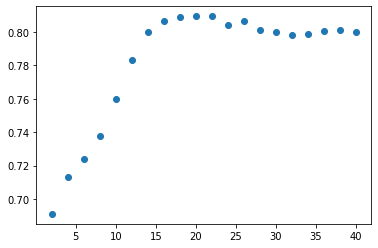

In [ ]:
plt.scatter(depths, val_acc)
# len(depth)


In [53]:
importances = model_gs.randomforestclassifier.feature_importances_

AttributeError: 'GridSearchCV' object has no attribute 'randomforestclassifier'

Text(0.5, 0, 'Gini Importance')

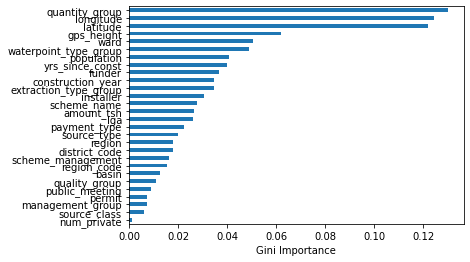

In [ ]:
features = X_train.columns

feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.head(100).plot(kind= 'barh')
plt.xlabel('Gini Importance')

## Create Kaggle Submission

**Task 8:** Load `'waterpumps/test.csv'` into a DataFrame named `X_test`. Generate a list of predictions, and then put them into a DataFrame `submission`. Be sure that `submission` has the same index as `X_test` and that the column name for your predictions is `'status_group'`.  

In [ ]:
# X_test = pd.read_csv(DATA_PATH + 'waterpumps/test_features.csv', index_col='id') ### This was already done
# YOUR CODE HERE
model = rf_model
X_test=X_test
submission=pd.DataFrame(model.predict(X_test), columns=['status_group'], index=X_test.index)
submission.head(25)

,status_group
id,
50785,non functional
51630,functional
17168,functional
45559,non functional
49871,functional
52449,functional
24806,non functional
28965,non functional
36301,non functional


**Test 8**

**Task 9 (`stretch goal`):** Save `submission` as a csv file using [`.to_csv()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html) and submit it to our Kaggle competition.

In [ ]:
# YOUR CODE HERE


In [ ]:
from google.colab import drive
drive.mount('drive')

In [ ]:
submission.to_csv('submission.csv')
!cp "submission.csv" "drive\My Drive"

In [ ]:
submission.to_csv()

## Explain

**Task 10 (`stretch goal`):** Make a horizontal barchart of the 10 most important features for your model.

In [ ]:
import matplotlib.pyplot as plt

# YOUR CODE HERE
raise NotImplementedError()